<a href="https://colab.research.google.com/github/basangoudapatil/ML-Notes/blob/main/NLP_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [35]:
import pandas as pd
import numpy as np

# text processing lib
import re
import string
import nltk
from nltk.corpus import stopwords

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import f1_score

import os 
import warnings
warnings.filterwarnings('ignore')



In [36]:
from sklearn.model_selection import StratifiedKFold

# **Load the DataSet**

In [37]:
test = pd.read_csv('/content/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [38]:
test.shape

(3263, 4)

In [39]:
train = pd.read_csv('/content/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [40]:
train.shape

(7613, 5)

# **Basic EDA**

In [41]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [42]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [43]:
# The target column in the Data is realted to a tweet which specifies Disaster or no
# Disaster => yes, else no
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

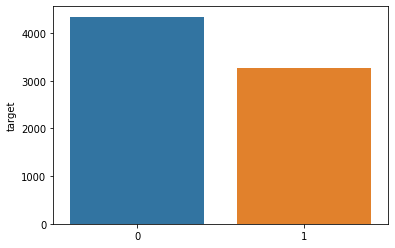

In [44]:
sns.barplot(train['target'].value_counts().index, train['target'].value_counts() )

In [45]:
disaster_tweet = train[train['target']==1]['text']
disaster_tweet.values[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [46]:
non_disaster_tweet = train[train['target']==0]['text']
non_disaster_tweet.values[1]

'I love fruits'

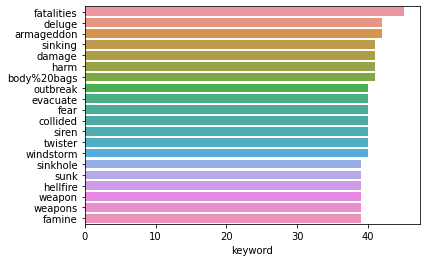

In [47]:
# keyword column
sns.barplot(y = train['keyword'].value_counts()[:20].index, x = train['keyword'].value_counts()[:20])

In [48]:
train.loc[train['text'].str.contains('disaster', na = False, case = False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

In [49]:
# Location column

train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

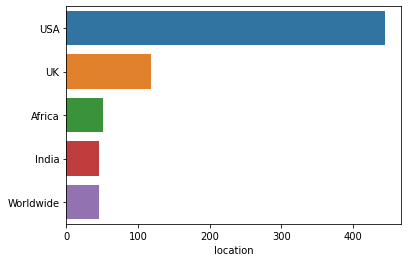

In [50]:
sns.barplot(y = train['location'].value_counts()[:5].index, x = train['location'].value_counts()[:5], orient = 'h')

# **Data Pre-Processing**

1. Data Cleaning

lower Case/Upper Case

remove noise

tokenization

remove stopwords

In [51]:
# 1. Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [52]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
from wordcloud import WordCloud

Text(0.5, 1.0, 'Non - Disaster Tweets')

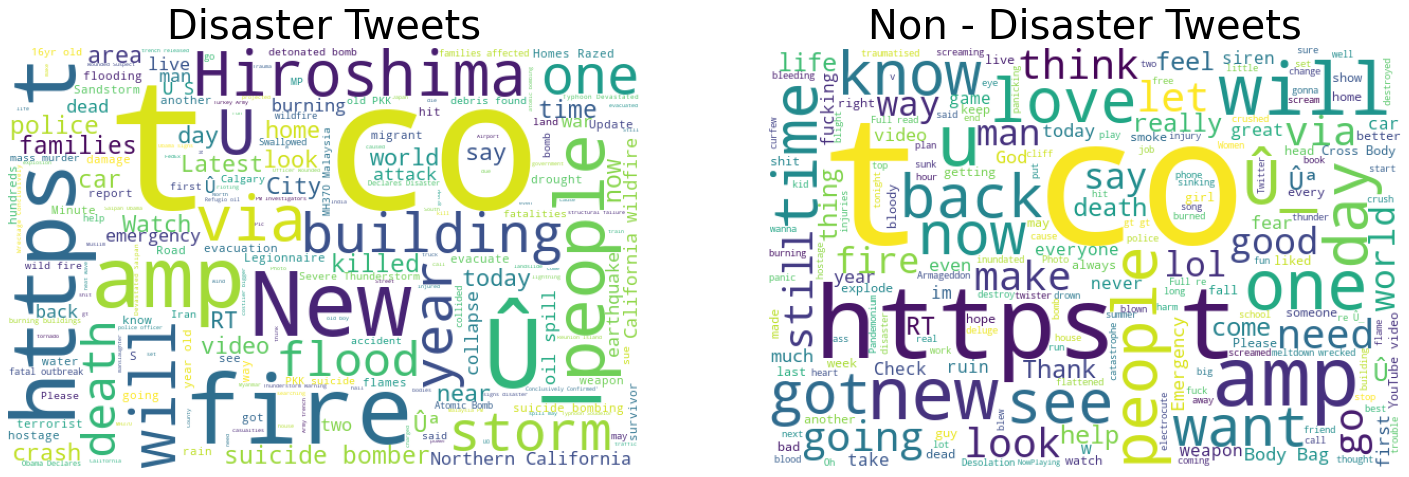

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (25,10))

# ax1 = disaster_tweet
wordcloud1 = WordCloud( background_color = 'white',
                       width = 600,
                       height = 400).generate(' '.join(disaster_tweet))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize=40)

# ax2 = non_disaster_tweet
wordcloud1 = WordCloud( background_color = 'white',
                       width = 600,
                       height = 400).generate(' '.join(non_disaster_tweet))
ax2.imshow(wordcloud1)
ax2.axis('off')
ax2.set_title('Non - Disaster Tweets', fontsize=40)

In [55]:
# 2. Tokenization

text = "Are you going, aren't you"

tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print('Example Text: ', text)
print('--------------------------------------------')
print('Tokenization by White Space: ', tokenizer1.tokenize(text))
print()
print('Tokenization by words using Tree Bank: ', tokenizer2.tokenize(text))
print()
print('Tokenization by Punctuation: ', tokenizer3.tokenize(text))
print()
print('Tokenization by Regular Expression: ', tokenizer4.tokenize(text))

Example Text:  Are you going, aren't you
--------------------------------------------
Tokenization by White Space:  ['Are', 'you', 'going,', "aren't", 'you']

Tokenization by words using Tree Bank:  ['Are', 'you', 'going', ',', 'are', "n't", 'you']

Tokenization by Punctuation:  ['Are', 'you', 'going', ',', 'aren', "'", 't', 'you']

Tokenization by Regular Expression:  ['Are', 'you', 'going', 'aren', 't', 'you']


In [56]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))

train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [57]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
# 3. Stopwords Removal

def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))

train['text'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [59]:
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [61]:
# 4. Token normalization
# Stemming
# Lemmatization

text = 'Feet cats wolves talked'

tokenizer = nltk.tokenize.TreebankWordTokenizer()

tokens = tokenizer.tokenize(text)

# stemmer
stemmer = nltk.stem.PorterStemmer()
print('Stemming the sentence: ',' '.join(stemmer.stem(token)for token in tokens))

# Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
print('Lemmatizing the Sentence: ',' '.join(lemmatizer.lemmatize(token)for token in tokens))


Stemming the sentence:  feet cat wolv talk
Lemmatizing the Sentence:  Feet cat wolf talked


In [62]:
# After Pre-Processing

def combine_text(list_of_text):
  combined_text = ' '.join(list_of_text)
  return combined_text

train['text'] = train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x: combine_text(x))

train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [63]:
# def text_preprocessing(text):
#   tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
#   nonpunc = clean_text(text)
#   tokenized_text = tokenizer.tokenize(nonpunc)
#   remove_stopwords = [w for w in tokenized_text if w not in stopwords.word('english')]

# **Transform tokens to Vectors**

In [32]:
# Bag of Words = CountVectorizer

count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


In [33]:
# TFIDF Feature

# TF = (Number of Items term t appears in the document)/(Number of terms in the Document)
# IDF = 1+log(N/n), N => number of documents, n => number of documents a term t has appeared in.
# TFIDF => TF * IDF

In [64]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range=(1,2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

# **Text Classification**

1. Logistic Regression

In [66]:
clf = LogisticRegression(C = 1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train['target'], cv = 5, scoring = 'f1')
scores

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [67]:
clf.fit(train_vectors, train['target'])

LogisticRegression()

In [69]:
clf_tfidf = LogisticRegression(C = 1.0)
scores_tfidf = model_selection.cross_val_score(clf_tfidf, train_tfidf, train['target'], cv = 5, scoring = 'f1')
scores_tfidf

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

2. Naives Bayes

In [70]:
clf_NB = MultinomialNB()
scores_NB = model_selection.cross_val_score(clf_NB, train_vectors, train['target'], cv = 5, scoring = 'f1')
scores_NB

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [71]:
clf_NB_tfidf = MultinomialNB()
scores_NB_tfidf = model_selection.cross_val_score(clf_NB_tfidf, train_tfidf, train['target'], cv = 5, scoring = 'f1')
scores_NB_tfidf

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

3. XG Boost

In [72]:
clf_XGB = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree = 0.8, subsample = 0.8, nthread = 10, learning_rate = 0.1)
scores_XGB = model_selection.cross_val_score(clf_XGB, train_vectors, train['target'], cv = 5, scoring = 'f1')
scores_XGB

array([0.47379913, 0.37379576, 0.43988816, 0.38900634, 0.53142857])

In [73]:
clf_XGB_tfidf = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree = 0.8, subsample = 0.8, nthread = 10, learning_rate = 0.1)
scores_XGB_tfidf = model_selection.cross_val_score(clf_XGB, train_tfidf, train['target'], cv = 5, scoring = 'f1')
scores_XGB_tfidf

array([0.48947951, 0.34406439, 0.43140965, 0.40084388, 0.53014354])